In [180]:
import numpy as np
import matplotlib.pyplot as plt
import requests

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[6,5]

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
print(data.shape)
print(names)
print(data[:,0])

(15, 8121)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']
['GRB230430A*' 'GRB230430325' '7:47:18.741' '184.7500' '43.0500'
 '3.979362' '0.3200' '0.1430' '7:47:18.741' '1.4842e-06' '1.2704e-08'
 '-999' '0.3200' 'True' '60064.32452247']


In [4]:
ra = np.array(data[3], dtype=float)
decl = np.array(data[4], dtype=float)
pos_error = np.array(data[5], dtype=float)
T90 = np.array(data[6], dtype=float)
T90_error = np.array(data[7], dtype=float)
fluence = np.array(data[9], dtype=float)
fluence_error = np.array(data[10], dtype=float)
redshift = np.array(data[11], dtype=float)

In [74]:
def right_labels(data, labels, center):
    a = np.where(data == max(data))
    if (labels[a] == 0):
        center=center[::-1]
        for i in range(len(data)):# invert labels for each sample
            if labels[i] == 0:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 0
    return labels, center

def right_labels_gauss(data, labels):
    a = np.where(data == max(data))
    if (labels[a] == 0):
        for i in range(len(data)):# invert labels for each sample
            if labels[i] == 0:
                labels[i] = 1
            elif labels[i] == 1:
                labels[i] = 0
    return labels

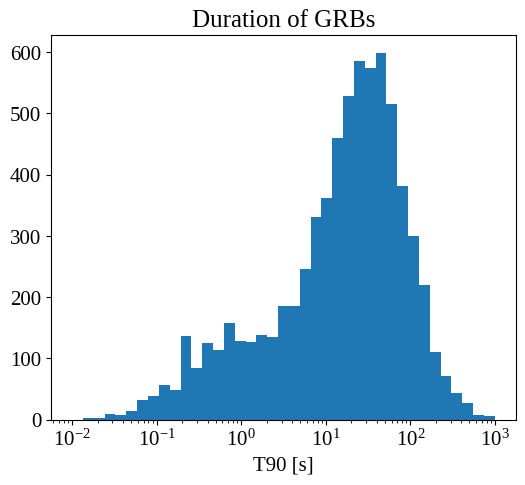

In [181]:
mask_T90 = T90>0
plt.hist(T90[mask_T90], bins=np.logspace(-2, 3, 40))
plt.title('Duration of GRBs')
plt.semilogx()
plt.xlabel('T90 [s]')
plt.show()

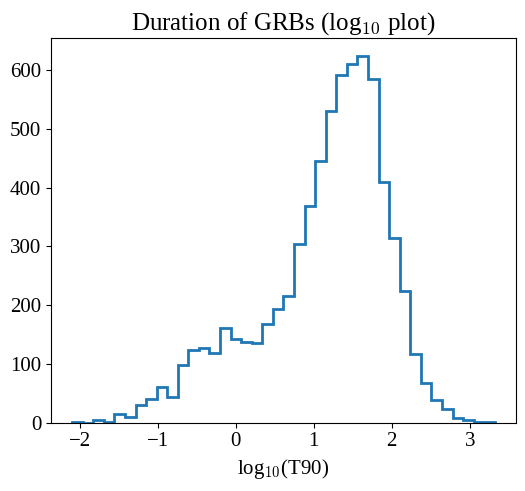

In [165]:
T90_cluster=np.log10(T90[mask_T90])

plt.hist(T90_cluster, bins=40, histtype='step', lw=2)
plt.title('Duration of GRBs (log$_{10}$ plot)')
plt.xlabel('log$_{10}$(T90)')
plt.show()

In [60]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

km = KMeans(n_clusters=2)
km.fit(T90_cluster[:, np.newaxis])
KMcenters = km.cluster_centers_
kmlabels = km.predict(T90_cluster[:, np.newaxis])
kmlabels, KMcenters = right_labels(T90_cluster, kmlabels, KMcenters)

/home/sale/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


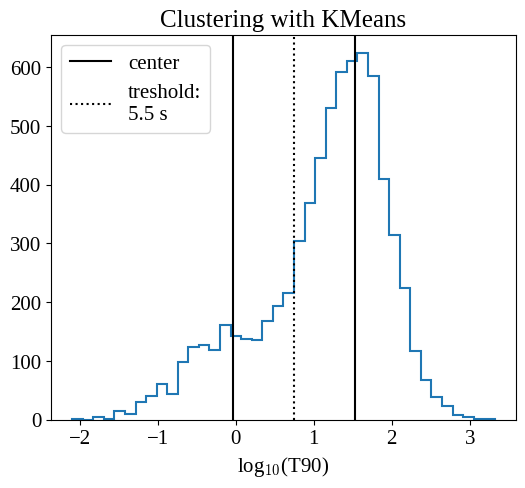

The centers of the two clusters are:  0.9 s and  33.7 s


In [61]:
KMshort = T90_cluster[kmlabels == 0]
KMlong = T90_cluster[kmlabels == 1]

KMtreshold = np.median([max(KMshort), min(KMlong)])

plt.hist(T90_cluster, bins=40, histtype='step', lw=1.5)
plt.title('Clustering with KMeans')
plt.xlabel('log$_{10}$(T90)')

plt.axvline(KMcenters[0],color='black', label='center')
plt.axvline(KMcenters[1],color='black')
plt.axvline(KMtreshold, color='black', linestyle='dotted', label = 'treshold:\n%s s' %round(10**KMtreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**KMcenters[0,0],1), 's and ', 
      round(10**KMcenters[1,0],1), 's')

In [9]:
#try now mean-shift

from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(T90_cluster[:,np.newaxis])
print(bandwidth)

0.5199912085392593


In [91]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=bandwidth)
ms.fit(scaler.fit_transform(T90_cluster[:,np.newaxis]))

MeanShift(bandwidth=0.5199912085392593)

In [92]:
MSlabels = ms.labels_
MScenters = scaler.inverse_transform(ms.cluster_centers_)
n_clusters = len(np.unique(MSlabels[MSlabels >= 0]))
print('bandwidth= ', round(bandwidth,3))
print("number of estimated clusters :", n_clusters)

MSlabels, MScenters = right_labels(T90_cluster, MSlabels, MScenters)

bandwidth=  0.52
number of estimated clusters : 2


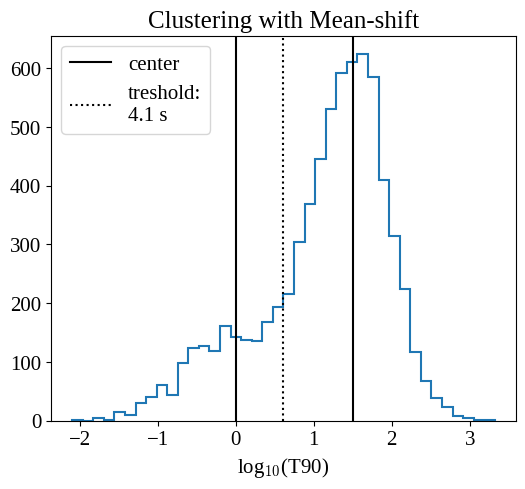

The centers of the two clusters are:  1.0 s and  31.9 s


In [66]:
plt.hist(T90_cluster, bins=40, histtype='step', lw=1.5)
plt.title('Clustering with Mean-shift')
plt.xlabel('log$_{10}$(T90)')

plt.axvline(MScenters[0],color='black', label='center')
plt.axvline(MScenters[1],color='black')

MSshort = T90_cluster[MSlabels == 1]
MSlong = T90_cluster[MSlabels == 0]

MStreshold = np.median([max(MSshort), min(MSlong)])

plt.axvline(MStreshold, color='black', linestyle='dotted', label = 'treshold:\n%s s' %round(10**MStreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**MScenters[0,0],1), 's and ', round(10**MScenters[1,0],1), 
      's')

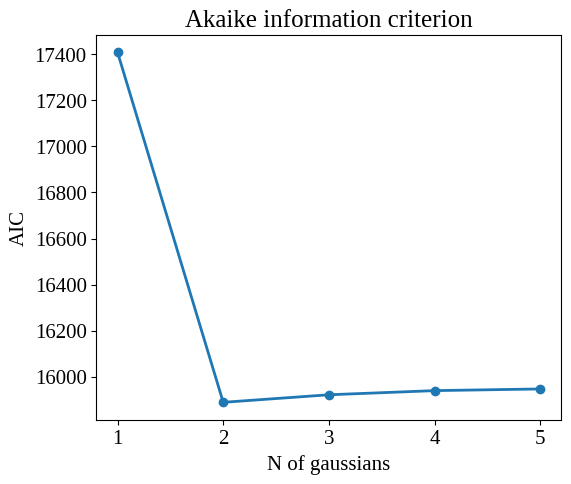

The best model is the one with  2  components


In [69]:
#let's try to use a gaussia mixture to find out if our data are described by 2 gaussian

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

components=np.linspace(1,5,5, dtype=int)

gm = np.array([GaussianMixture(n_components=c).fit(T90_cluster[:,np.newaxis]) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm[i].aic(T90_cluster[:,np.newaxis])
    
plt.plot(components, AIC, lw=2)
plt.scatter(components, AIC)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model=components[min_i]

print("The best model is the one with ", best_model, " components")

GaussianMixture(n_components=2)


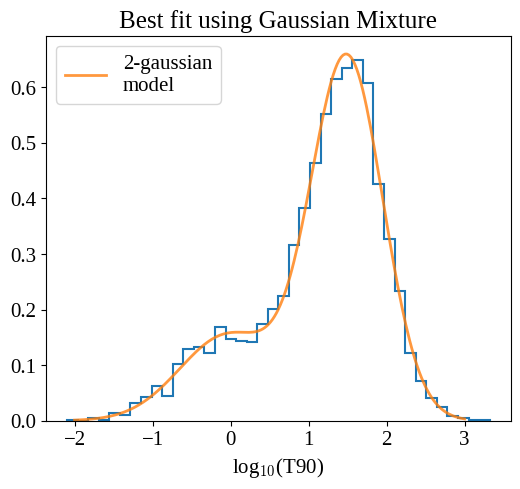

In [70]:
#plot now the fit, to visually verify its correctness

best_model=gm[min_i]
print(best_model)

plt.hist(T90_cluster, bins=40, histtype='step', density=True, lw=1.5)
plt.title('Best fit using Gaussian Mixture')
plt.xlabel('log$_{10}$(T90)')

xgrid=np.linspace(-2, 3, 200)

plt.plot(xgrid, np.exp(best_model.score_samples(xgrid[:, np.newaxis])), lw=2, label='2-gaussian\nmodel', alpha=0.8)
plt.legend()
plt.show()

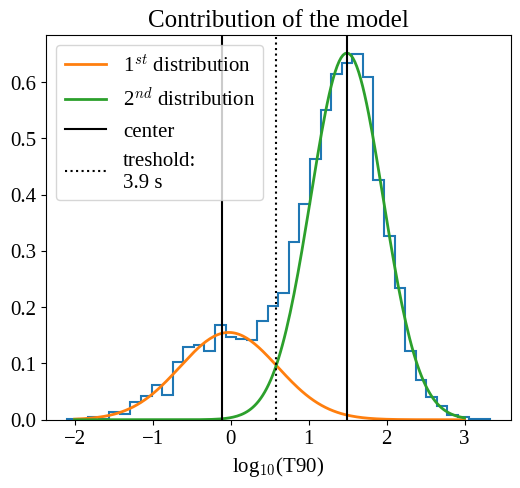

The centers of the two clusters are:  0.8 s and  30.7 s


In [76]:
#plot the contribution of each gaussian distribution

contr=best_model.predict_proba(xgrid[:, np.newaxis])
pdf=np.exp(best_model.score_samples(xgrid[:, np.newaxis]))
pdf_contr=contr*pdf[:, np.newaxis]

gmlabels = best_model.predict(T90_cluster[:, np.newaxis])

gmlabels = right_labels_gauss(T90_cluster, gmlabels)

GMshort = T90_cluster[gmlabels == 0]
GMlong = T90_cluster[gmlabels == 1]

GMtreshold = np.median([max(GMshort), min(GMlong)])
GMcenters = [np.median(GMshort), np.median(GMlong)]

plt.hist(T90_cluster, bins=40, histtype='step', density=True, lw=1.5)

plt.plot(xgrid, pdf_contr[:,0], lw=2, label='1$^{st}$ distribution')
plt.plot(xgrid, pdf_contr[:,1], lw=2, label='2$^{nd}$ distribution')
plt.xlabel('log$_{10}$(T90)')
plt.title('Contribution of the model')

plt.axvline(GMcenters[0],color='black', label='center')
plt.axvline(GMcenters[1],color='black')

plt.axvline(GMtreshold, color='black', linestyle='dotted', label = 'treshold:\n%s s' %round(10**GMtreshold,1))

plt.legend()
plt.show()

print('The centers of the two clusters are: ', round(10**GMcenters[0],1), 's and ', round(10**GMcenters[1],1), 's')

In [77]:
#comparison between the three models
#compare the treshold

print('Treshold found with: \n KMeans: ', round(10**KMtreshold,1), 's\n Mean-Shift: ', round(10**MStreshold,1), 
      's\n Gaussian Mixture:', round(10**GMtreshold,1), 's')

print('Centers of the two groups (Short GRB and Long GRB): \n KMeans:', round(10**KMcenters[0,0],1), 's and ', 
      round(10**KMcenters[1,0],1), 's\n Mean-Shift: ', round(10**MScenters[0,0],1), 's and ', 
      round(10**MScenters[1,0],1), 's\n Gaussian Mixture:', round(10**GMcenters[0],1), 's and ', 
      round(10**GMcenters[1],1), 's')

Treshold found with: 
 KMeans:  5.5 s
 Mean-Shift:  4.1 s
 Gaussian Mixture: 3.9 s
Centers of the two groups (Short GRB and Long GRB): 
 KMeans: 0.9 s and  33.7 s
 Mean-Shift:  1.0 s and  31.9 s
 Gaussian Mixture: 0.8 s and  30.7 s


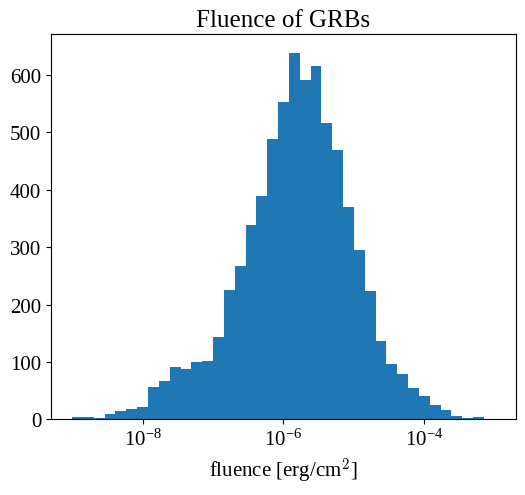

In [17]:
#other variables show this bimodality?

mask_f = fluence>0
plt.hist(fluence[mask_f], bins=np.logspace(-9, -3, 40))
plt.title('Fluence of GRBs')
plt.semilogx()
plt.xlabel('fluence [erg/cm$^2$]')
plt.show()

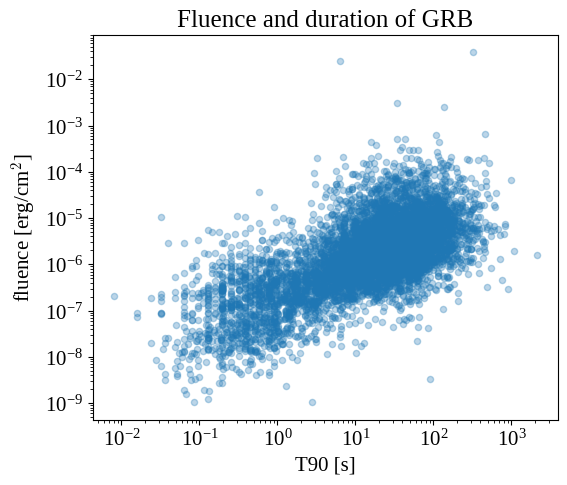

In [173]:
mask_Tf=np.logical_and(T90>0, fluence>0)

plt.scatter(T90[mask_Tf], fluence[mask_Tf], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Fluence and duration of GRB')
plt.xlabel('T90 [s]')
plt.ylabel('fluence [erg/cm$^2$]')

plt.show()

In [79]:
#try a 2d clustering to verify if are able to find tha bimodality

T90_2d=np.log10(T90[mask_Tf])
fluence_2d=np.log10(fluence[mask_Tf])

X = np.concatenate([T90_2d[:,np.newaxis],fluence_2d[:,np.newaxis]], axis=1)

km_2d = KMeans(n_clusters=2) #Try 2 clusters to start with
km_2d.fit(X)
KMcenters_2d = km_2d.cluster_centers_ #location of the clusters
KMlabels_2d = km_2d.predict(X)

/home/sale/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


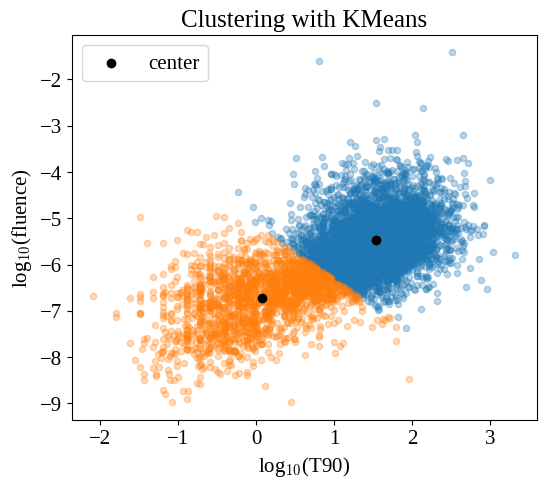

The centers of the two clusters are:
 T90= 34.1 s and fluence= 3.41e-06 erg/cm2 
 T90= 1.2 s and fluence= 2e-07 erg/cm2


In [80]:
for ii in range(2):
    plt.scatter(X[KMlabels_2d==ii,0], X[KMlabels_2d==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with KMeans')

plt.scatter(KMcenters_2d[0,0], KMcenters_2d[0,1], label='center', c='black')
plt.scatter(KMcenters_2d[1,0], KMcenters_2d[1,1], c='black')

plt.legend()
plt.show()

print('The centers of the two clusters are:\n T90=', round(10**KMcenters_2d[0,0],1), 's and fluence=', 
      round(10**KMcenters_2d[0,1],8), 'erg/cm2 \n T90=', round(10**KMcenters_2d[1,0],1), 's and fluence=', 
      round(10**KMcenters_2d[1,1],7), 'erg/cm2')

In [21]:
#try Mean-shift

bandwidth_2d = estimate_bandwidth(X)
print(bandwidth_2d)

0.9192651712495231


In [22]:
scaler = preprocessing.StandardScaler()
ms_2d = MeanShift(bandwidth=bandwidth_2d)
ms_2d.fit(scaler.fit_transform(X))

MeanShift(bandwidth=0.9192651712495231)

In [23]:
MSlabels_2d = np.unique(ms_2d.labels_)
n_clusters_2d = len(MSlabels_2d[MSlabels_2d >= 0])
print(MSlabels_2d)
print('bandwidth= ', round(bandwidth_2d,3))
print("number of estimated clusters :", n_clusters_2d)

[0 1 2 3]
bandwidth=  0.919
number of estimated clusters : 4


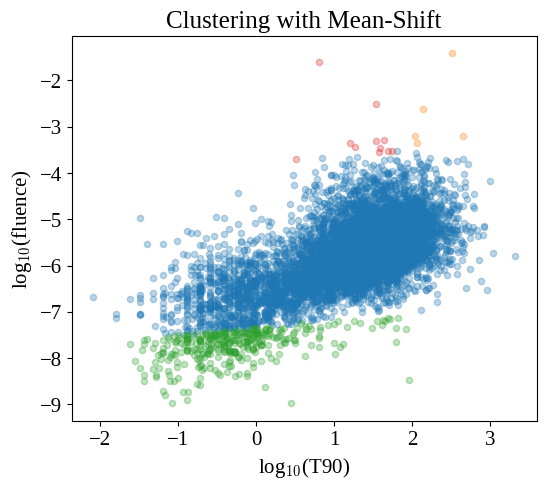

In [24]:
#4 clusters!

for ii in range(4):
    plt.scatter(X[ms_2d.labels_==ii,0], X[ms_2d.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift')

plt.show()

In [26]:
#try to increase the value of the bandwidth to try to absorb the 2 small clusters

scaler = preprocessing.StandardScaler()
ms_2d_2 = MeanShift(bandwidth=bandwidth_2d*1.6)
ms_2d_2.fit(scaler.fit_transform(X))

MeanShift(bandwidth=1.470824273999237)

In [27]:
MSlabels_2d_2 = np.unique(ms_2d_2.labels_)
n_clusters_2d_2 = len(MSlabels_2d_2[MSlabels_2d_2 >= 0])
print(MSlabels_2d_2)
print('bandwidth= ', round(bandwidth_2d*1.6,3))
print("number of estimated clusters :", n_clusters_2d_2)

[0 1]
bandwidth=  1.471
number of estimated clusters : 2


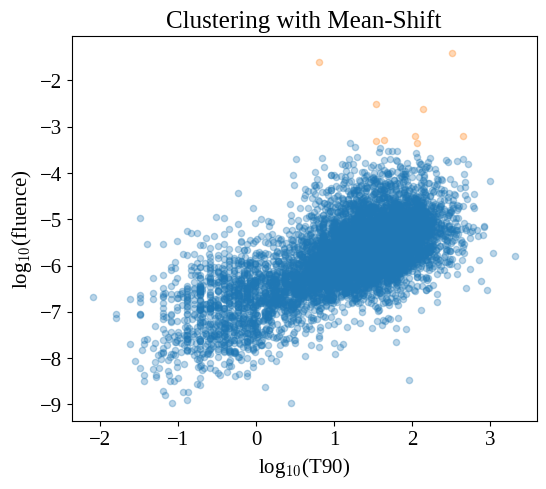

In [28]:
for ii in range(2):
    plt.scatter(X[ms_2d_2.labels_==ii,0], X[ms_2d_2.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift')

plt.show()

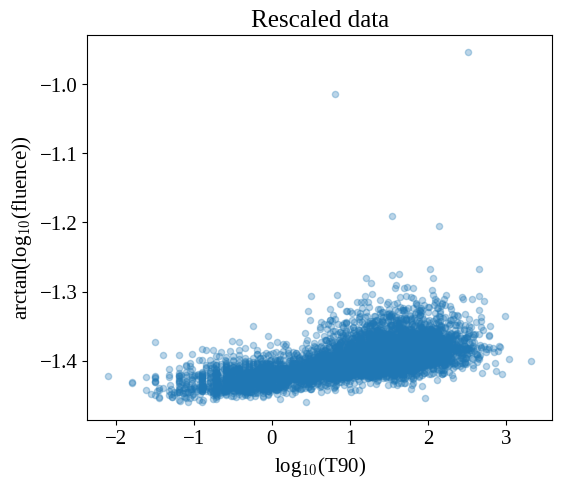

In [86]:
#try to rescale the data as arctan(X)

X_scale = np.concatenate([T90_2d[:,np.newaxis],np.arctan(fluence_2d[:,np.newaxis])], axis=1)
plt.scatter(X_scale[:,0], X_scale[:,1], alpha=0.3, s=20)

plt.xlabel('log$_{10}$(T90)')
plt.ylabel('arctan(log$_{10}$(fluence))')
plt.title('Rescaled data')

plt.show()

In [87]:
bandwidth_2d_s = estimate_bandwidth(X_scale)
print(bandwidth_2d_s)

0.5178474442247577


In [96]:
scaler = preprocessing.StandardScaler()
ms_2d_s = MeanShift(bandwidth=bandwidth_2d_s*2)
ms_2d_s.fit(scaler.fit_transform(X_scale))

MeanShift(bandwidth=1.0356948884495154)

In [97]:
MSlabels_2d_s = np.unique(ms_2d_s.labels_)
n_clusters_2d_s = len(np.unique(MSlabels_2d_s[MSlabels_2d_s >= 0]))
print(MSlabels_2d_s)
print('bandwidth= ', round(bandwidth_2d_s,3))
print("number of estimated clusters :", n_clusters_2d_s)

[0 1 2 3]
bandwidth=  0.518
number of estimated clusters : 4


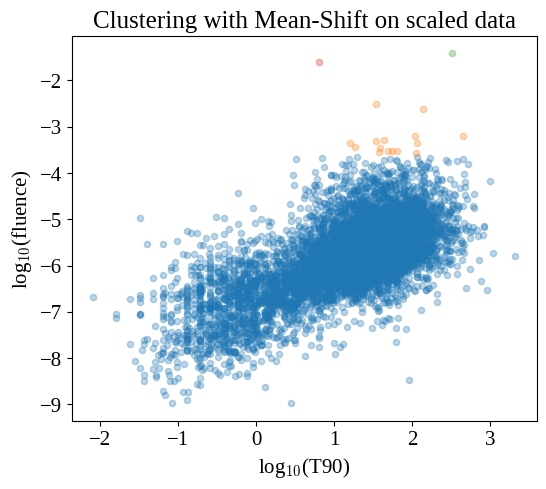

In [103]:
for ii in range(n_clusters_2d_s):
    plt.scatter(X[ms_2d_s.labels_==ii,0], X[ms_2d_s.labels_==ii,1], alpha=0.3, s=20)
    
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')
plt.title('Clustering with Mean-Shift on scaled data')

plt.show()

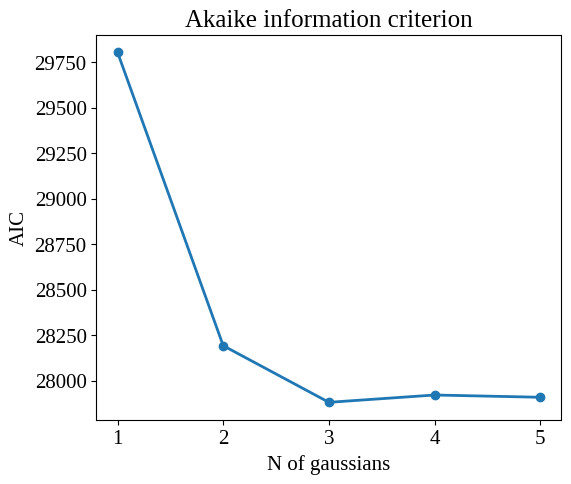

The best model is the one with  3  components


In [27]:
#try gaussian mixture

components=np.linspace(1,5,5, dtype=int)

gm_2d = np.array([GaussianMixture(n_components=c).fit(X) for c in components])

#compute the AIC and plot its values as a function of the number of the gaussian
AIC=np.empty(len(components))
for i in range(len(components)):
    AIC[i] = gm_2d[i].aic(X)
    
plt.plot(components, AIC, lw=2)
plt.scatter(components, AIC)
plt.ylabel('AIC')
plt.xlabel('N of gaussians')
plt.title('Akaike information criterion')
plt.show()

min_i=np.argmin(AIC)
best_model_c=components[min_i]

print("The best model is the one with ", best_model_c, " components")

GaussianMixture(n_components=3)


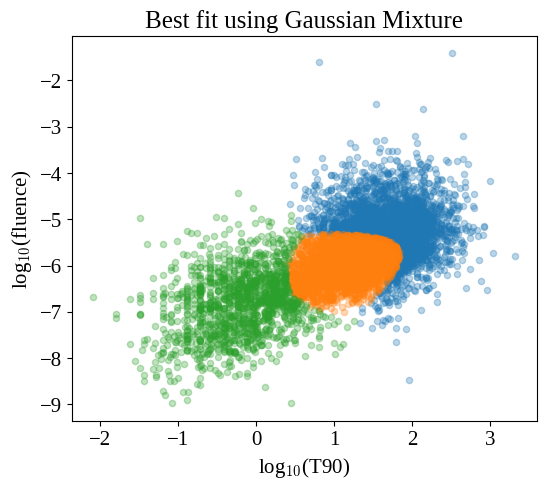

In [29]:
best_model_2d=gm_2d[min_i]
print(best_model_2d)

GMlabels_2d = best_model_2d.predict(X)

for ii in range(best_model_c):
    plt.scatter(X[GMlabels_2d==ii,0], X[GMlabels_2d==ii,1], alpha=0.3, s=20)

plt.title('Best fit using Gaussian Mixture')
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')

plt.show()

GaussianMixture(n_components=2)


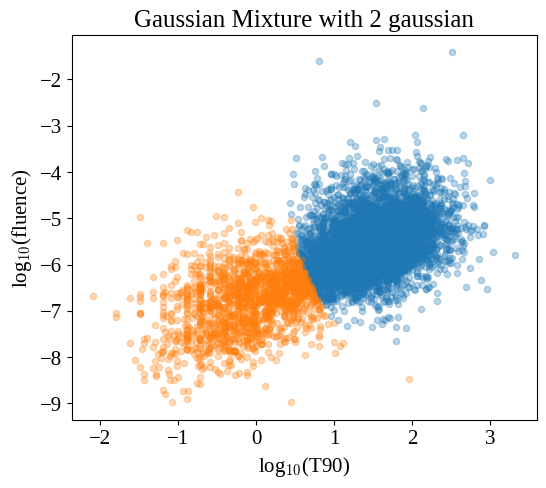

In [35]:
#force two gaussians

GM_2g_model=gm_2d[1]
print(GM_2g_model)

GMlabels_2d_2 = GM_2g_model.predict(X)

for ii in range(2):
    plt.scatter(X[GMlabels_2d_2==ii,0], X[GMlabels_2d_2==ii,1], alpha=0.3, s=20)

plt.title('Gaussian Mixture with 2 gaussian')
plt.xlabel('log$_{10}$(T90)')
plt.ylabel('log$_{10}$(fluence)')

plt.show()

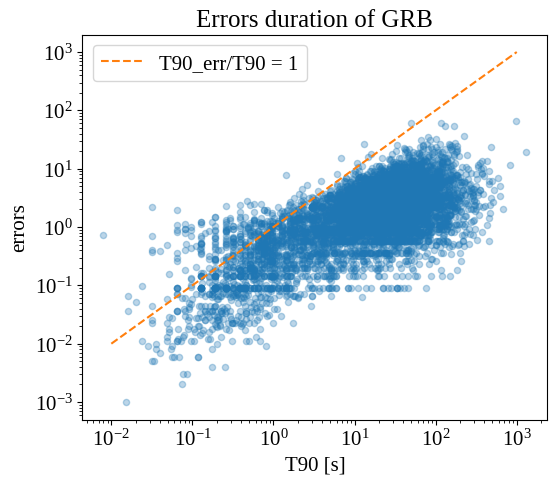

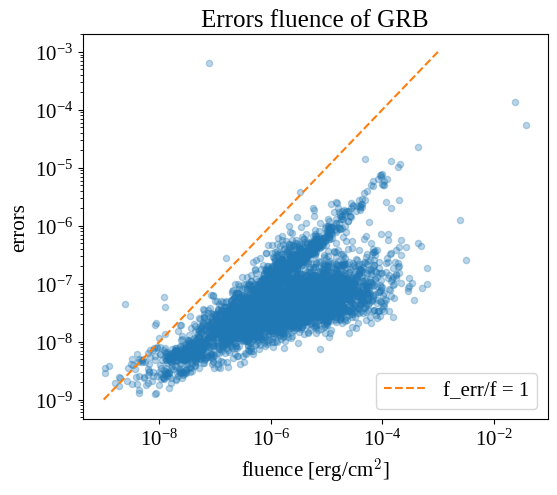

In [30]:
#errors

mask_Terr=np.logical_and(T90>0, T90_error>0)

plt.scatter(T90[mask_Terr], T90_error[mask_Terr], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Errors duration of GRB')
plt.xlabel('T90 [s]')
plt.ylabel('errors')
xgrid=np.logspace(-2,3,4)
plt.plot(xgrid,xgrid, c='C1', ls='--', label='T90_err/T90 = 1')
plt.legend()

plt.show()

mask_ferr=np.logical_and(fluence>0, fluence_error>0)

plt.scatter(fluence[mask_Terr], fluence_error[mask_Terr], alpha=0.3, s=20)
plt.semilogx()
plt.semilogy()
plt.title('Errors fluence of GRB')
plt.xlabel('fluence [erg/cm$^2$]')
plt.ylabel('errors')
xgrid=np.logspace(-9,-3,4)
plt.plot(xgrid,xgrid, c='C1', ls='--', label='f_err/f = 1')
plt.legend()

plt.show()